# Kannada MNIST - Hyerin Lee

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('train_df.csv')
test = pd.read_csv('test_df.csv')

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test.head()

,Unnamed: 0,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,57808,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4960,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,35755,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15543,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,48968,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
X_train = train.drop(['label'], axis=1).values
y = train['label'].values

X_test = test.iloc[:,1:].values
test_id = test.iloc[:,0]

In [5]:
from keras.utils import to_categorical
y_train = to_categorical(y)
y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [6]:
print(X_train.shape, y_train.shape, X_test.shape) #28*28 크기의 2D 배열
print(X_train.dtype, y_train.dtype, X_test.dtype) #각 feature은 픽셀의 강도를 의미(0부터 255까지의 정수)

(42000, 784) (42000, 10) (18000, 784)
int64 float32 int64


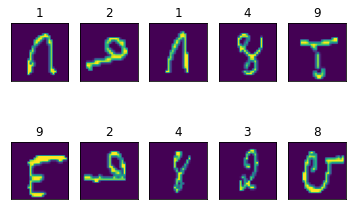

In [7]:
# train data 일부 나타내기

fig = plt.figure()
rn = np.random.choice(X_train.shape[0], 10, replace=False)

for i in range(10):
    subplot = fig.add_subplot(2,5,i+1)
    subplot.set_xticks([])
    subplot.set_yticks([]) 
    
    image = X_train[rn[i]].reshape(28,28)
    subplot.imshow(image, 'viridis')
    subplot.set_title('%s' %y[rn[i]])

In [8]:
from sklearn.model_selection import train_test_split 

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
print(X_train.shape, X_valid.shape)
print(y_train.shape, y_valid.shape)

(37800, 784) (4200, 784)
(37800, 10) (4200, 10)


In [9]:
import tensorflow as tf
import keras

In [10]:
print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.3


In [11]:
# GPU 셋팅 확인
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 856937750444179524,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 1795832632251451622
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10705787679859588919
 physical_device_desc: "device: XLA_GPU device"]

## Neural Network

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

### Vanishing Gradient & Exploding Gradient 
  
vanishing gradient는 알고리즘이 하위층으로 진행될수록 그레디언트가 점점 작아져서 훈련이 좋은 솔루션으로 미치지 않는 것이고,  
exploding gradient는 그레디언트가 점점 커져서 알고리즘이 발산하는 문제이다.  

특히 2000년 초까지 심층 신경망을 사용할 때 로지스틱 시그모이드 활성화 함수와 가중치를 평균이 0이고 분산이 1인 정규분포로 초기화하는 법을 많이 사용했는데 이는 각 층에서 출력의 분산이 입력의 분산보다 크게 만들어, 알고리즘을 발산하게끔 만들었다고 한다. (2000년대 초까지 심층 신경망을 많이 사용하지 않았던 이유.)  
  
이 때, gradient의 불안정성을 완화할 수 있는 방법(=입출력의 분산을 비슷하게 만드는 방법)은 다음과 같다.
> 1. 가중치 초기화  
> 2. 수렴하지 않는 활성화 함수 사용(LeakyRELU, ELU, SELU)  
> 3. Batch Normalization  

### model1
> val_acc : 0.9802  

hidden layers | activation function | Initializer | Batch Normalization | Dropout | Optimizer | epochs
:-: | :-: | :-: | :-: | :-: | :-: | :-:
3 | relu | He_Uniform | True | 0.2 | adam | 20
  
값이 음수일 때 gradient가 소실되는 문제가 있는 relu 함수를 사용하는 대신, He_Uniform 초기화를 사용해주었다.

In [16]:
model1 = Sequential()
model1.add(Dense(32, activation='relu', input_shape=(784,)))
model1.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(10, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model1.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.4143 - accuracy: 0.8715 - val_loss: 0.1570 - val_accuracy: 0.9593
Epoch 2/20
1182/1182 [==============================] - 2s 1ms/step - loss: 0.1582 - accuracy: 0.9531 - val_loss: 0.1053 - val_accuracy: 0.9683
Epoch 3/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1192 - accuracy: 0.9643 - val_loss: 0.0965 - val_accuracy: 0.9683
Epoch 4/20
1182/1182 [==============================] - 2s 1ms/step - loss: 0.0969 - accuracy: 0.9710 - val_loss: 0.1339 - val_accuracy: 0.9724
Epoch 5/20
1182/1182 [==============================] - 2s 1ms/step - loss: 0.0854 - accuracy: 0.9744 - val_loss: 0.0991 - val_accuracy: 0.9726
Epoch 6/20
1182/1182 [==============================] - 2s 1ms/step - loss: 0.0737 - accuracy: 0.9780 - val_loss: 0.0937 - val_accuracy: 0.9700
Epoch 7/20
1182/1182 [==============================] - 2s 1ms/step - loss: 0.0706 - accuracy: 0.9783 - val_loss: 0.0833 - val_accuracy:

### model2
> val_acc : 0.981

hidden layers | activation function | Initializer | Batch Normalization | Dropout | Optimizer | epochs
:-: | :-: | :-: | :-: | :-: | :-: | :-:
3 | Leaky relu | He_Uniform | True | 0.2 | adam | 20
  
보통 ReLU 보다는 Leaky ReLU가 대부분의 경우 성능이 좋다고 한다. 이 모델도 마찬가지로 He_Uniform 초기화를 사용하였다.  
* ReLU 계열의 함수들은 kernel initializer로 He 를 사용한다.

In [21]:
model2 = Sequential([
    keras.layers.Dense(32, input_shape=(784,)),
    keras.layers.Dense(64, kernel_initializer='he_uniform'),
    keras.layers.LeakyReLU(alpha=0.2), # alpha : 음수값일 때 함수의 기울기 
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, kernel_initializer='he_uniform'),
    keras.layers.LeakyReLU(alpha=0.2), 
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, kernel_initializer='he_uniform'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model2.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.3186 - accuracy: 0.9000 - val_loss: 0.1379 - val_accuracy: 0.9588
Epoch 2/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1685 - accuracy: 0.9494 - val_loss: 0.1150 - val_accuracy: 0.9674
Epoch 3/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1433 - accuracy: 0.9555 - val_loss: 0.0993 - val_accuracy: 0.9714
Epoch 4/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1242 - accuracy: 0.9617 - val_loss: 0.1070 - val_accuracy: 0.9698
Epoch 5/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1135 - accuracy: 0.9649 - val_loss: 0.0991 - val_accuracy: 0.9743
Epoch 6/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1040 - accuracy: 0.9680 - val_loss: 0.0982 - val_accuracy: 0.9748
Epoch 7/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1002 - accuracy: 0.9687 - val_loss: 0.0932 - val_accuracy:

같은 구조에 activation function만 ReLU에서 LeakyReLU로 바꿨을 때 val_acc는 정말 소폭 증가하였다.

### model3
> val_acc : 0.9805

hidden layers | activation function | Initializer | Batch Normalization | Dropout | Optimizer | epochs
:-: | :-: | :-: | :-: | :-: | :-: | :-:
3 | ELU | He_Uniform | True | 0.2 | adam | 20
  
ELU 모델도 마찬가지로 He_Uniform 초기화를 사용하였다.  

In [23]:
model3 = Sequential([
    keras.layers.Dense(32, input_shape=(784,)),
    keras.layers.Dense(64, activation='elu',kernel_initializer='he_uniform'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='elu', kernel_initializer='he_uniform'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
model3.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.3137 - accuracy: 0.9024 - val_loss: 0.1342 - val_accuracy: 0.9631
Epoch 2/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1577 - accuracy: 0.9527 - val_loss: 0.1239 - val_accuracy: 0.9643
Epoch 3/20
1182/1182 [==============================] - 2s 2ms/step - loss: 0.1313 - accuracy: 0.9603 - val_loss: 0.1099 - val_accuracy: 0.9671
Epoch 4/20
1182/1182 [==============================] - 2s 1ms/step - loss: 0.1120 - accuracy: 0.9662 - val_loss: 0.0970 - val_accuracy: 0.9710
Epoch 5/20
1182/1182 [==============================] - 2s 1ms/step - loss: 0.1037 - accuracy: 0.9683 - val_loss: 0.0919 - val_accuracy: 0.9755
Epoch 6/20
1182/1182 [==============================] - 2s 1ms/step - loss: 0.0964 - accuracy: 0.9701 - val_loss: 0.0856 - val_accuracy: 0.9767
Epoch 7/20
1182/1182 [==============================] - 2s 1ms/step - loss: 0.0841 - accuracy: 0.9737 - val_loss: 0.0915 - val_accuracy:

ReLU 계열 activation function을 사용한 세 가지 모델의 val_acc는 약 0.98로 매우 비슷했다.  
이는 gradient 손실 혹은 폭주 문제를 해결해주는 강력한 방법 중 하나인 Batch Normalization을 매 경우 사용했기 때문에 활성화 함수의 차이로 인한 val_acc 차이가 크지 않았던 것이 아닌가 라는 생각이 들었다.  
  
Batch Normalization은 
* 거의 모든 심층 신경망에서 성능을 크게 향상시키며,
* 그레디언트 소실 문제가 크게 감소하여 하이퍼볼릭 탄젠트나 로지스틱 활성화 함수와 같이 수렴성을 가진 활성화 함수를 사용할 수 있게 하고,  
* 규제와 같은 역할을 하여 Dropout, L1 L2 regularization과 같은 다른 규제 기법의 필요성을 줄여준다.  
(그러나 이에 대한 기여도는 매우 높은 편은 아니기 때문에 드롭아웃을 함께 사용하는 것이 좋다.)
* 배치 정규화마다 추가적인 계산이 이루어지기 때문에 에포크마다 더 많은 시간이 걸리지만, 수렴하는 데에 걸리는 시간이 훨씬 짧아지므로 보통 상쇄된다고 한다.  
  
Batch Normalizaion을 제거했을 때 얼마나 큰 영향을 미칠지 확인해보기 위해 model4를 생성한다.

### model4
> val_acc : 0.9486

hidden layers | activation function | Initializer | Batch Normalization | Dropout | Optimizer | epochs
:-: | :-: | :-: | :-: | :-: | :-: | :-:
3 | ELU | He_Uniform | **False** | 0.2 | adam | 20

In [25]:
model4 = Sequential([
    keras.layers.Dense(32, input_shape=(784,)),
    keras.layers.Dense(64, activation='elu',kernel_initializer='he_uniform'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation='elu', kernel_initializer='he_uniform'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(10, activation='softmax')
])

model4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model4.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1182/1182 [==============================] - 2s 1ms/step - loss: 8.6742 - accuracy: 0.5875 - val_loss: 0.9755 - val_accuracy: 0.7760
Epoch 2/20
1182/1182 [==============================] - 2s 1ms/step - loss: 1.0145 - accuracy: 0.7296 - val_loss: 0.7440 - val_accuracy: 0.8426
Epoch 3/20
1182/1182 [==============================] - 1s 1ms/step - loss: 0.7604 - accuracy: 0.7986 - val_loss: 0.4299 - val_accuracy: 0.9002
Epoch 4/20
1182/1182 [==============================] - 1s 1ms/step - loss: 0.5548 - accuracy: 0.8481 - val_loss: 0.3932 - val_accuracy: 0.9117
Epoch 5/20
1182/1182 [==============================] - 2s 1ms/step - loss: 0.4649 - accuracy: 0.8748 - val_loss: 0.3115 - val_accuracy: 0.9271
Epoch 6/20
1182/1182 [==============================] - 2s 1ms/step - loss: 0.4171 - accuracy: 0.8865 - val_loss: 0.3080 - val_accuracy: 0.9288
Epoch 7/20
1182/1182 [==============================] - 1s 1ms/step - loss: 0.3868 - accuracy: 0.8968 - val_loss: 0.3027 - val_accuracy:

model3과 같은 조건에서 배치 정규화 레이어만 삭제했을 때 val_acc가 0.9805에서 0.9486으로 매우 많이 떨어졌다.

## Randomized GridSearch  
  
사실 Randomized GridSearch를 통해서 학습 시간은 줄이고 최적의 모수를 찾을 수 있는 방향으로 작업을 진행해보려 했으나 코드에 계속 오류가 나서 아쉬운 마음에 코드라도 첨부해봅니다,,, (총총) 왜 그런지 이유는 알아내지 못했슴니당,,, 흑흑

In [ ]:
'''
def build_model(hidden_nodes, act, batch_num, drop_num, opt_list, lr):
    
    model = Sequential()
    model.add(Dense(hidden_nodes, activation=act, input_shape=(784,)))
    
    model.add(Dense(hidden_nodes, activation=act))
    if batch_num!=0:
        model.add(BatchNormalization())
    if drop_num!=0 : 
        model.add(Dropout(drop_num))
    
    model.add(Dense(hidden_nodes, activation=act))
    if batch_num != 0:
        model.add(BatchNormalization())
    if drop_num != 0:
        model.add(Dropout(drop_num))              
    
    model.add(Dense(hidden_nodes, activation=act))
    if batch_num != 0:
        model.add(BatchNormalization())
    if drop_num != 0:
        model.add(Dropout(drop_num))
    
    opt = getattr(keras.optimizers, opt_list)(learning_rate=lr)
    model.add(Dense(10, activation='softmax'))                  
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model
'''

In [ ]:
'''
search_model = KerasClassifier(build_fn=build_model, verbose=3)

param_grid = {
    'hidden_nodes' : [32, 64, 128, 256],
    'act' : ['relu'], 'batch_num' : [0,1], 'drop_num' : [0, 0.2, 0.4],
    'opt_list' : ['adam', 'RMSprop'], 'lr' : [0.01, 0.005, 0.001]
}

rnd_search_cv = RandomizedSearchCV(search_model, param_grid, cv=3, scoring='accuracy')
rnd_result = rnd_search_cv.fit(X_train, y_train)

'''

## CNN  
  
Kannada MNIST 데이터의 경우 CNN(Convolution Neural Network)을 사용하여 높은 accuracy를 낸 사람들을 Kaggle에서 많이 볼 수 있었다. 그래서 추가적으로 CNN을 공부하고 이를 활용한 모델을 만들어봤다.  

이미지 인식 문제에 일반적인 완전연결층의 심층신경망을 사용하지 않는 이유는, 완전연결층의 심층신경망은 작은 이미지에서는 잘 작동하지만 아주 큰 이미지에서는 너무 많은 파라미터가 만들어지기 때문이라고 한다.
  
일반적인 CNN 구조는 다음과 같다.
> 입력 - (합성곱 - 풀링) * N번  - 완전연결  

* 합성곱 (Conv2D) : 입력층의 일부를 각 필터가 일정 간격(스트라이드)에 따라서 연결. 하나의 합성곱 층은 입력에 여러 필터를 동시에 적용하여 입력에 있는 여러 특성을 감지함.
* 풀링 (MaxPool2D) : 과대적합 위험을 줄이기 위해 파라미터 수를 줄이는 입력 이미지의 축소본을 만드는 것. 각 커널 내에서 가장 큰 입력값이 다음 층으로 전달됨.
* 완전연결 (Flatten) : Flatten 함수를 이용하여 입력을 일렬로 펼치고, 과대적합을 막기 위해 dropout(ex 50%)을 진행함.

In [19]:
# scaling and reshaping

X_train = (X_train / 255).reshape(X_train.shape[0], 28, 28, 1) #28 height, 28 width, 1 channel
X_valid = (X_valid / 255).reshape(X_valid.shape[0], 28, 28, 1) #28 height, 28 width, 1 channel
X_test = (X_test / 255).reshape(X_test.shape[0], 28, 28, 1) #28 height, 28 width, 1 channel

In [20]:
print(X_train.shape, X_valid.shape, X_test.shape)

(37800, 28, 28, 1) (4200, 28, 28, 1) (18000, 28, 28, 1)


In [21]:
seed = 42
np.random.seed(seed)

### model5 
> train_acc : 0.9991  
val_acc : 0.9950  
test_acc : 0.99518

전형적인 CNN 구조를 적용한 모델이며 층을 많이 쌓지는 않았다.

In [33]:
model5 = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=5, padding='same', activation='relu', input_shape=[28,28,1]), #입력
    # padding='valid' : 스트라이드에 따라 입력 이미지의 아래와 오른쪽 행, 열이 무시될 수 있다.
    # padding='same' : 입력 이미지가 무시되지 않고 모두 출력됨
    keras.layers.BatchNormalization(),
    
    keras.layers.Conv2D(64, kernel_size=5, padding='same', activation='relu'), # 합성곱
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(2), #풀링
    
    keras.layers.Flatten(), #완전연결
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(10, activation='softmax') #출력
])

In [30]:
model5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization_19 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 64)        51264     
_________________________________________________________________
batch_normalization_20 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 12544)             0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 12544)            

In [34]:
model5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model5.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1182/1182 [==============================] - 123s 104ms/step - loss: 0.1077 - accuracy: 0.9678 - val_loss: 0.0371 - val_accuracy: 0.9883
Epoch 2/30
1182/1182 [==============================] - 123s 104ms/step - loss: 0.0388 - accuracy: 0.9879 - val_loss: 0.0455 - val_accuracy: 0.9874
Epoch 3/30
1182/1182 [==============================] - 122s 103ms/step - loss: 0.0310 - accuracy: 0.9903 - val_loss: 0.0250 - val_accuracy: 0.9919
Epoch 4/30
1182/1182 [==============================] - 127s 107ms/step - loss: 0.0266 - accuracy: 0.9917 - val_loss: 0.0329 - val_accuracy: 0.9912
Epoch 5/30
1182/1182 [==============================] - 127s 107ms/step - loss: 0.0255 - accuracy: 0.9924 - val_loss: 0.0282 - val_accuracy: 0.9926
Epoch 6/30
1182/1182 [==============================] - 119s 100ms/step - loss: 0.0163 - accuracy: 0.9949 - val_loss: 0.0286 - val_accuracy: 0.9912
Epoch 7/30
1182/1182 [==============================] - 119s 100ms/step - loss: 0.0188 - accuracy: 0.9939 - val_

In [35]:
y_pred = model5.predict_classes(X_test)
y_pred

submissions = pd.DataFrame({'Id' : np.array(test_id), 'Category' : y_pred})
submissions.to_csv("submission5.csv", index=False, header=True)

## model6 (Best Model)
> train acc : 0.9987  
val acc : 0.9952  
test acc : 0.99703  
  
좀 더 깊은 신경망을 사용했기 때문에 overfitting 문제를 예방하기 위해
* 풀링에선 stride 크기를 늘려서 다음층으로 출력되는 크기를 줄였다  
* 완전연결층에서 dropout 비율을 조금 더 높게 설정해주었다.  
  
그 결과 model5와 비슷한 val acc를 가졌으나 test acc는 꽤 더 높은 값을 얻을 수 있었다. (overfitting 개선!)

In [92]:
model6 = keras.models.Sequential([
    
    keras.layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28,28,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)), #stride 옵션을 바꾸어 진행함.
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(10, activation = "softmax")
])

In [93]:
model6.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
batch_normalization_16 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 28, 28, 32)        25632     
_________________________________________________________________
batch_normalization_17 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
dropout_12 (Dropout)         (None, 14, 14, 32)       

In [87]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

model6.compile(optimizer = optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
# optimizer는 그 전과 다르게 RMSprop을 사용했다.(rho가 작을수록 gradient를 더 크게 반영함)

In [88]:
model6.fit(X_train, y_train, epochs=30, validation_data=(X_valid, y_valid))

Epoch 1/30
1182/1182 [==============================] - 147s 125ms/step - loss: 0.1101 - accuracy: 0.9675 - val_loss: 0.0339 - val_accuracy: 0.9921
Epoch 2/30
1182/1182 [==============================] - 146s 124ms/step - loss: 0.0451 - accuracy: 0.9878 - val_loss: 0.0307 - val_accuracy: 0.9926
Epoch 3/30
1182/1182 [==============================] - 146s 124ms/step - loss: 0.0335 - accuracy: 0.9903 - val_loss: 0.0252 - val_accuracy: 0.9929
Epoch 4/30
1182/1182 [==============================] - 149s 126ms/step - loss: 0.0289 - accuracy: 0.9919 - val_loss: 0.0180 - val_accuracy: 0.9957
Epoch 5/30
1182/1182 [==============================] - 150s 127ms/step - loss: 0.0218 - accuracy: 0.9937 - val_loss: 0.0201 - val_accuracy: 0.9945
Epoch 6/30
1182/1182 [==============================] - 149s 126ms/step - loss: 0.0222 - accuracy: 0.9943 - val_loss: 0.0308 - val_accuracy: 0.9938
Epoch 7/30
1182/1182 [==============================] - 145s 123ms/step - loss: 0.0231 - accuracy: 0.9939 - val_

In [90]:
y_pred = model6.predict_classes(X_test)
y_pred

submissions = pd.DataFrame({'Id' : np.array(test_id), 'Category' : y_pred})
submissions.to_csv("submission6.csv", index=False, header=True)

추후 kannada mnist의 notebook 파일을 찾아보니 분석가들은 과적합을 예방하기 위해 Data Augmentation과 Learning rate reduction을  
주로 이용하는 듯 하여 진행해봤다.
[출처1](https://www.kaggle.com/shahules/indian-way-to-learn-cnn) / [출처2](https://www.kaggle.com/benanakca/kannada-mnist-cnn-tutorial-with-app-top-2)  

* **Data Augmentation**
과적합을 예방하기 위해 기존 데이터와 기존 데이터에 약간의 변화를 준 데이터를 함께 사용하는 방법. 단기간에 성능을 높이기 좋으며 옵션으로는 회전, 자르기, 좌우반전, 밝기 조절, 줌, 이동 등이 있다. data augmentation을 이용한 cnn 모델로는 AlexNet, VGGNet, ResNet 등이 있다고 한다. (이건 다음 cnn 시간에 공부해보겠슴니당...) 

* **Learning Schedule**  
큰 학습률로 시작하고 학습 속도가 느려질 때 학습률을 낮추는 방법. 여러가지 전략이 있으나 지수 기반 스케줄링, 성능 기반 스케줄링, 1사이클 스케줄링이 뛰어난 성능을 보인다. 그중에서도 kaggle의 많은 ranker들이 사용한 성능 기반 스케줄링을 실행하기 위해 ReduceLROnPlateau callback을 사용해봤다.

## model7
> train acc : 0.9975  
val acc : 0.9962  
test acc : 0.99648
  
* model6과 같은 조건에서 Data Augmentation과 성능 기반 학습률 스케줄링을 추가함.

In [36]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [48]:
model7 = keras.models.Sequential([ #model6과 동일
    
    keras.layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28,28,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)), #stride 옵션을 바꾸어 진행함.
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(10, activation = "softmax")
])

In [49]:
image_fn = ImageDataGenerator(
        rotation_range=10,  # 이미지를 랜덤하게 회전하는 범위.
        zoom_range = 0.1, # 이미지를 랜덤하게 줌하는 범위 
)

lr_fn = ReduceLROnPlateau(monitor='val_loss', # val_loss를 기준으로 삼아 학습률 스케줄링 진행 
                          patience=3, # 세번 이내에 val_acc가 개선되지 않으면 learning rate change
                          verbose=1,
                          factor=0.5, # learning rate를 줄이는 factor. lr <- lr * factor
                          min_lr=0.00001) # 최소 leraning_rate

In [50]:
optimizer = keras.optimizers.RMSprop(rho=0.9, epsilon=1e-08, decay=0.0)
model7.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

In [51]:
history7 = model7.fit_generator(image_fn.flow(X_train,y_train),
                              epochs = 30, validation_data = (X_valid,y_valid),callbacks=[lr_fn])

Epoch 1/30
1182/1182 [==============================] - 152s 128ms/step - loss: 0.1304 - accuracy: 0.9615 - val_loss: 0.0432 - val_accuracy: 0.9886
Epoch 2/30
1182/1182 [==============================] - 155s 131ms/step - loss: 0.0557 - accuracy: 0.9842 - val_loss: 0.0290 - val_accuracy: 0.9926
Epoch 3/30
1182/1182 [==============================] - 149s 126ms/step - loss: 0.0464 - accuracy: 0.9870 - val_loss: 0.0297 - val_accuracy: 0.9929
Epoch 4/30
1182/1182 [==============================] - 152s 128ms/step - loss: 0.0406 - accuracy: 0.9888 - val_loss: 0.0211 - val_accuracy: 0.9945
Epoch 5/30
1182/1182 [==============================] - 156s 132ms/step - loss: 0.0339 - accuracy: 0.9904 - val_loss: 0.0233 - val_accuracy: 0.9940
Epoch 6/30
1182/1182 [==============================] - 153s 129ms/step - loss: 0.0319 - accuracy: 0.9912 - val_loss: 0.0201 - val_accuracy: 0.9950
Epoch 7/30
1182/1182 [==============================] - 149s 126ms/step - loss: 0.0307 - accuracy: 0.9916 - val_

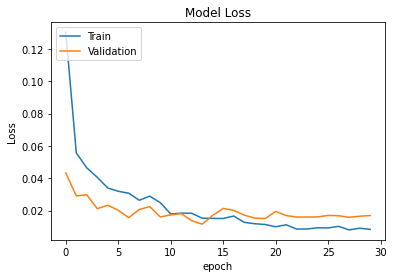

In [54]:
plt.plot(history7.history['loss'])
plt.plot(history7.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

train data의 경우 epoch가 늘어날수록 loss가 줄어들었지만 validation data의 경우 오히려 epoch가 15가 넘어가자 증가했다.

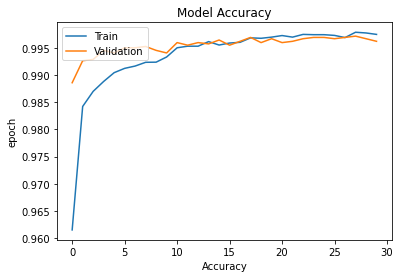

In [56]:
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('epoch')
plt.xlabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

log를 살펴보면 learning rate가 epoch가 20이 넘어가기 시작한 순간부터는 0.00001에 근접하기 시작했다. (매우 작은 수...)  
epoch가 20이상일 때는 사실상 학습되는 양이 크지 않았고 이로 인해 data augmentation을 추가했음에도 불구하고 accuracy가 증가하지 못한 것이 아닌가 라는 생각이 든다. 이 추측이 맞는지 확인해보기 위해 학습률 스케줄링을 제거하고 정말 마지막으로 모델을 굴려본다,,,

In [52]:
y_pred = model7.predict_classes(X_test)
y_pred

submissions = pd.DataFrame({'Id' : np.array(test_id), 'Category' : y_pred})
submissions.to_csv("submission7.csv", index=False, header=True)

In [61]:
keras.backend.clear_session() # RAM 사용량을 줄이기 위해 한번 클리어 해준다... 내 노트북아 미안,,, 

## model8
> train acc : 0.9956
val acc : 0.9957
test acc : 0.99648
  
* model6과 같은 조건에서 Data Augmentation만 추가함. (학습률은 일정)

In [62]:
model8 = keras.models.Sequential([ #model6, 7과 동일
    
    keras.layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28,28,1)),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=(2,2)), #stride 옵션을 바꾸어 진행함.
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.25),
    
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(256, activation = "relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    
    keras.layers.Dense(10, activation = "softmax")
])

In [63]:
optimizer = keras.optimizers.RMSprop(lr = 0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model8.compile(loss='categorical_crossentropy', optimizer = optimizer, metrics=['accuracy'])

In [64]:
history8 = model8.fit_generator(image_fn.flow(X_train,y_train), epochs = 30, validation_data = (X_valid,y_valid))

Epoch 1/30
1182/1182 [==============================] - 148s 125ms/step - loss: 0.1263 - accuracy: 0.9625 - val_loss: 0.0330 - val_accuracy: 0.9905
Epoch 2/30
1182/1182 [==============================] - 146s 124ms/step - loss: 0.0535 - accuracy: 0.9847 - val_loss: 0.0360 - val_accuracy: 0.9907
Epoch 3/30
1182/1182 [==============================] - 147s 124ms/step - loss: 0.0445 - accuracy: 0.9876 - val_loss: 0.0335 - val_accuracy: 0.9919
Epoch 4/30
1182/1182 [==============================] - 146s 124ms/step - loss: 0.0370 - accuracy: 0.9895 - val_loss: 0.0184 - val_accuracy: 0.9952
Epoch 5/30
1182/1182 [==============================] - 146s 124ms/step - loss: 0.0341 - accuracy: 0.9909 - val_loss: 0.0197 - val_accuracy: 0.9933
Epoch 6/30
1182/1182 [==============================] - 146s 124ms/step - loss: 0.0323 - accuracy: 0.9914 - val_loss: 0.0230 - val_accuracy: 0.9948
Epoch 7/30
1182/1182 [==============================] - 146s 124ms/step - loss: 0.0293 - accuracy: 0.9919 - val_

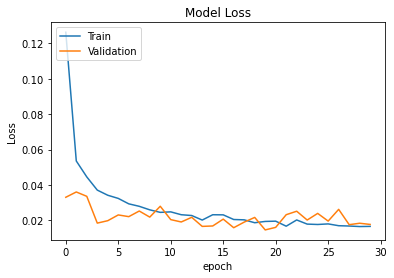

In [66]:
plt.plot(history8.history['loss'])
plt.plot(history8.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

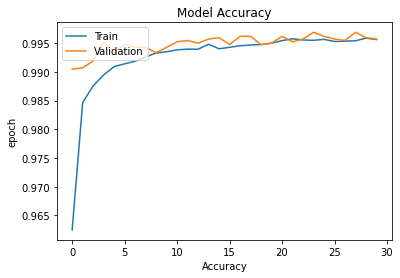

In [67]:
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('epoch')
plt.xlabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [68]:
y_pred = model8.predict_classes(X_test)
y_pred

submissions = pd.DataFrame({'Id' : np.array(test_id), 'Category' : y_pred})
submissions.to_csv("submission8.csv", index=False, header=True)

같은 조건에서 학습률 스케줄링만 제거해본 결과, train acc 와 valid acc는 상대적으로 이 모델이 낮았으나 test acc는 소름돋게도 같은 값이 나왔다....!
train valid data를 사용했을 때보다 test accuracy가 더 높았던 것으로 보아 더 general한 모델을 도출했다는 것에 의의를 두고 싶다 ^^... (미련 뚝뚝,,,)

## Conclusion  
  
  
### Model1 ~ Model4 : Neural Network  
* ReLU 활성화 함수를 사용한 Model1, Leaky ReLU 를 사용한 Model2, ELU를 사용한 Model3를 비교해봤을 때 Leaky ReLU를 사용한 모델이 가장 accuracy가 높았다. (weight_initializer = He_Uniform)  
* Model3, Model4의 경우 모두 ELU를 사용하였지만 차이점은 Model4는 Batch Normalization을 사용하지 않았다. 그 결과, val_acc가 0.9805에서 0.9486으로 매우 많이 떨어졌다. 이처럼 Batch Normalization은 심층 신경망에서 성능을 향상 시킬 수 있는 좋은 도구이다. (덤으로 규제하는 역할까지 수행한다니 참 멋있는 친구이다... 그래도 이 역할을 크게하는 편은 아니니 dropout은 사용하는 편이 좋다고 한다.)  
  
  
### Model5 ~ Model8 : CNN  
* 층을 깊게 쌓지 않은 Model5는 성능이 별로였다.
* 같은 구조에서 Model7은 학습률 스케줄링과 Data Augmentation을, Model8은 Data Augmentation을, 그리고 Model6은 아무것도 적용하지 않았는데 Model6의 test_acc가 가장 좋았다. 성능을 더 높여보고 싶었지만 쉽지 않은 것 같다. CNN에 있는 여러 유명한 모델들은 다음 세션에서 공부하고 적용해보겠습니다...! 감사합니다 ㅎㅎ